<a href="https://www.kaggle.com/code/manoj21k/sentiment-analysis-with-word2vec-rnn?scriptVersionId=142642833" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Steps followed in this notebook for Sentiment analysis of Tweets**

    1. Importing the raw data of tweets
    2. preprocessing of the tweets
    3. Creating Embeddings using Word2Vec
    4. Building RNN model
    5. Interpreting the model
    6. Evaluating the model
    7. Saving the model
    8. Predition on new tweet

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
import re 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/contractions/contractions.csv


In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
dataset.shape

(1600000, 6)

In [4]:
dataset = dataset[['sentiment', 'tweet']]
dataset.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
#unique values of sentiment
dataset['sentiment'].unique()

array([0, 4])

In [6]:
#replacing 4 with 1 for positive sentiment
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [7]:
dataset['sentiment'].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

**Preprocessing the Text**

The Preprocessing steps taken are:

1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs**: Links starting with 'http' or 'https' or 'www' are replaced by '<url>'.
3. **Replacing Usernames:** Replace @Usernames with word '<user>'. [eg: '@Kaggle' to '<user>'].
4. **Replacing Emojis:** Replace emojis by using a regex expression. [eg: ':)' to '<smile>']
5. **Replacing Contractions:** Replacing contractions with their meanings. [eg: "can't" to 'can not']
6. **Removing Non-Alphabets:** Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.

In [8]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('../input/contractions/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [9]:
contractions_dict

{"'aight": 'alright',
 "ain't": 'is not',
 "amn't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 'dunno': 'do not know',
 "d'ye": 'do you',
 "e'er": 'ever',
 "everybody's": 'everybody is',
 "everyone's": 'everyone is',
 'finna': 'fixing',
 "g'day": 'good day',
 'gimme': 'give me',
 "giv'n": 'given',
 'gonna': 'going to',
 "gon't": 'go not',
 'gotta': 'got to',
 "hadn't": 'had not',
 "had've": 'had have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had',
 "he'll": 'he will',
 "he's": 'he is',
 "he've": 'he have',
 "how'd": 'how did',
 'howdy': 'how do you do',
 "how'll": 'how will',
 "how're": 'how are',
 "how's": 'how is',
 "i'd\ti": 'had',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'm": 'i am',
 "i'm'a": 'i am abo

In [10]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [11]:
dataset['processed_text'] = dataset.tweet.apply(preprocess_apply)

In [12]:
dataset.head()

,sentiment,tweet,processed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",<user> <url> awww thatis a bummer you sho...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,<user> i dived many times for the ball manage...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",<user> no it is not behaving at all i am mad...


In [13]:
dataset['tweet'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [14]:
dataset['processed_text'][0]

'<user> <url>   awww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>'

In [15]:
#splitting the data
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=32, stratify=y_data)

In [17]:
X_train.shape, X_test.shape

((1120000,), (480000,))

In [18]:
y_train.shape, y_test.shape

((1120000,), (480000,))

**Creating Word Embedding Using Word2Vec**

In [19]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

#creating the List of words for training data
Word2Vec_training_data = list(map(lambda x: x.split(), X_train))

In [20]:
Word2Vec_training_data[0]

['i',
 'keep',
 'checking',
 'my',
 'phone',
 'for',
 'msgs',
 'then',
 'remembering',
 'it',
 'is',
 'not',
 'on',
 'silent',
 'any',
 'more',
 'nigelnofriends']

In [21]:
word2vec_model = Word2Vec(Word2Vec_training_data,
                        vector_size=Embedding_dimensions,
                        workers=8,
                        min_count=5)

In [22]:
word2vec_model.wv[1]

array([ 0.5294265 ,  2.53724   ,  0.6676488 ,  1.607369  ,  1.5571676 ,
       -0.27088654,  1.5473069 ,  1.1751578 , -0.5979051 , -0.06607468,
        0.41188267, -1.1869434 ,  0.0994671 ,  0.84718865,  0.17835292,
        0.11869888,  1.6213698 , -0.14245412, -0.00559912,  0.6437681 ,
       -0.7303937 , -0.04677762,  0.99976057,  0.05830661, -1.355186  ,
       -0.7477808 , -1.0038581 ,  0.07151697,  1.1353271 ,  0.63620764,
       -1.104761  ,  0.47696292,  0.8250562 ,  0.30053475,  1.1151525 ,
       -1.0122591 ,  0.62065715, -0.5862484 , -0.2205569 ,  0.6168445 ,
       -0.05681443, -0.19423354, -1.5345654 ,  1.4217821 , -0.11575553,
        3.7576618 , -0.9088733 , -0.89878494,  0.47897285, -0.9047864 ,
       -0.2510109 , -0.42162532,  0.68857604,  0.18074884,  0.7126483 ,
       -0.58915776, -0.59381   ,  0.02900251, -0.6169794 , -0.15323414,
       -1.6332356 ,  1.339476  ,  0.88437915,  0.24532667,  0.9629635 ,
        0.32509637,  1.8803117 ,  1.3547134 , -1.6691357 ,  2.01

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [24]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [25]:
input_length = 60

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1120000, 60)
X_test.shape : (480000, 60)


In [27]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2,
        243, 1284,    8,  212,   14, 6902,   96, 4822,    9,    7,   12,
         18, 4558,  187,   88,    1], dtype=int32)

In [28]:
second_key, second_value = list(tokenizer.word_index.items())[1]
print("Second Key:", second_key)
print("Second Value:", second_value)

Second Key: i
Second Value: 2


In [29]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [30]:
# Reverse the mapping of tokens to words
index_to_word = {token: word for word, token in tokenizer.word_index.items()}
fifth_word = index_to_word[5]
fifth_word

'the'

In [31]:
embedding_matrix[5]

array([-2.08229113,  1.65053737, -0.84299219, -0.60051972,  1.62463522,
        0.34974083,  0.42711475, -0.13816927,  1.51111078, -0.65885937,
        1.3455373 ,  0.83341485,  0.83068705, -0.28746355,  1.26740456,
        1.22661805,  1.70766723, -0.70931703,  1.41339946,  0.39959535,
       -1.12390316, -0.15940426,  1.14006388,  2.49081016, -0.48701578,
        0.84347653,  0.30449241,  0.35340574,  1.39362788,  1.99951363,
       -0.98426431,  1.16950428, -0.48710075, -1.64563131,  0.70122623,
        1.63411129, -0.19134998, -1.51869726, -1.52915049,  1.14276063,
       -0.29888648,  1.96657288,  3.90683722, -1.93183684,  3.71072507,
        0.70406288,  0.08330134, -1.69559228,  0.55849344, -2.57563043,
        2.22268248, -1.62919748, -0.50724769, -0.33143327, -1.52176952,
       -0.46777597, -0.88271296,  0.56603515, -1.94353044, -0.68074065,
        0.87090325,  0.41725689, -0.85342282,  0.29261166, -1.11480451,
       -2.10860467,  0.570912  ,  0.04420933, -0.26256806, -1.70

In [32]:
word2vec_model.wv.most_similar('man')

[('dude', 0.6533661484718323),
 ('boy', 0.647927463054657),
 ('guy', 0.6378806233406067),
 ('girl', 0.5933501124382019),
 ('woman', 0.5512814521789551),
 ('kid', 0.5507686138153076),
 ('cow', 0.5308318138122559),
 ('gosh', 0.5229153633117676),
 ('bastard', 0.5212906002998352),
 ('chick', 0.5202022790908813)]

**Creating the RNN model**

In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding

In [34]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        SimpleRNN(100, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [35]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,021,733
Trainable params: 21,733
Non-trainable params: 6,000,000
_________________________________________________________________


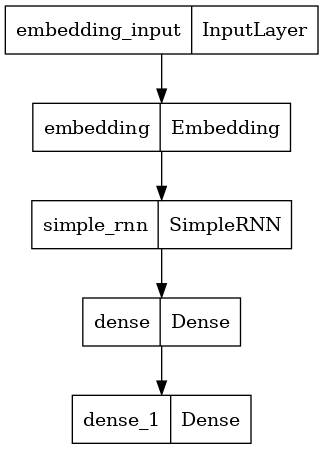

In [36]:
import tensorflow as tf
tf.keras.utils.plot_model(
    training_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [37]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/12
985/985 [==============================] - 70s 62ms/step - loss: 0.4973 - accuracy: 0.7601 - val_loss: 0.4644 - val_accuracy: 0.7836
Epoch 2/12
985/985 [==============================] - 60s 61ms/step - loss: 0.4455 - accuracy: 0.7929 - val_loss: 0.4351 - val_accuracy: 0.7983
Epoch 3/12
985/985 [==============================] - 62s 63ms/step - loss: 0.4284 - accuracy: 0.8017 - val_loss: 0.4301 - val_accuracy: 0.8020
Epoch 4/12
985/985 [==============================] - 60s 61ms/step - loss: 0.4192 - accuracy: 0.8072 - val_loss: 0.4180 - val_accuracy: 0.8082
Epoch 5/12
985/985 [==============================] - 60s 61ms/step - loss: 0.4129 - accuracy: 0.8103 - val_loss: 0.4148 - val_accuracy: 0.8080
Epoch 6/12
985/985 [==============================] - 62s 62ms/step - loss: 0.4084 - accuracy: 0.8133 - val_loss: 0.4698 - val_accuracy: 0.7812
Epoch 7/12
985/985 [==============================] - 60s 61ms/step - loss: 0.4340 - accuracy: 0.8007 - val_loss: 0.4196 - val_accuracy:

**Evaluating the Model**

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

15000/15000 [==============================] - 116s 8ms/step


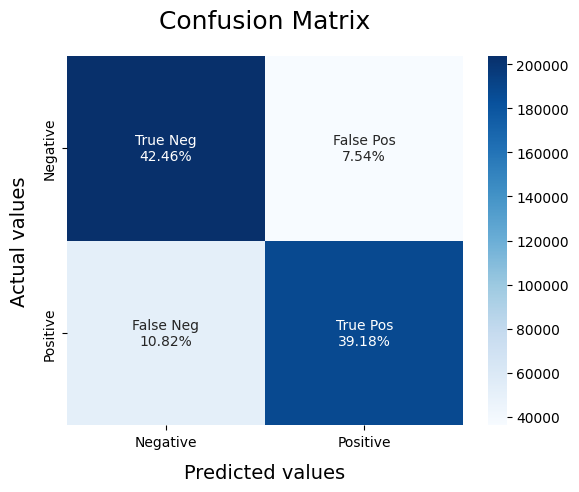

In [40]:

# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

**SAVING THE MODEL**

In [41]:
import pickle 
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-RNN')
training_model.save_weights("Model Weights/weights")

**Prediction on new data**

In [42]:
import pickle
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

from gensim.models import KeyedVectors

# Load the Word2Vec model as a KeyedVectors object
word2vec_model1 = KeyedVectors.load('Word2Vec-twitter-100')


# Load the tokenizer
with open('Tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the TF-Model
training_model = load_model('Sentiment-RNN')

In [43]:
new_tweet = "Today has been a terrible day. Nothing is going my way, and it feels like everything is falling apart. #badluck #feelingdown 😞"

# Tokenize and pad the new tweet
input_length = 60  # Adjust this to match the input length used during training
new_tweet_tokens = tokenizer.texts_to_sequences([new_tweet])
new_tweet_tokens_padded = pad_sequences(new_tweet_tokens, maxlen=input_length)

In [44]:
# Predict sentiment for the new tweet
sentiment_probabilities = training_model.predict(new_tweet_tokens_padded)

# If it's binary sentiment classification (positive/negative), you can use argmax to get the predicted sentiment
predicted_sentiment = "Positive" if sentiment_probabilities[0][0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 171ms/step
Predicted Sentiment: Negative


In [45]:
tweet_embeddings = training_model.layers[0](new_tweet_tokens_padded).numpy()

In [46]:
import numpy as np
np.set_printoptions(threshold=np.inf)

print(tweet_embeddings)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000